In [1]:
import numpy as np
import matplotlib.pyplot as plt
import requests
import pandas as pd
import json

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Rappel du sujet

- 15 actifs min et 40 max
- chaque actif ne doit pas etre superieux a 10% du portefeuille

# Manager API

In [83]:

class RESTManager:
    HOST_NAME = "dolphin.jump-technology.com"
    PORT = "8443"

    URL = "https://" + HOST_NAME + ":" + PORT + "/api/v1/"

    USERNAME_USER1 = "EPITA_GROUPE8"
    PASSWORD_USER1 = "AgLyQx64Jw6pAkW9"

    auth = (USERNAME_USER1, PASSWORD_USER1)


    def get(self, path):
        return requests.get(self.URL+path, auth=self.auth, verify=False).text
    
    def put(self, path, data):
        return requests.put(self.URL+path, auth=self.auth, data=data, verify=False)
    
    def post(self, path, data):
        return requests.post(self.URL+path, auth=self.auth, data=data, verify=False)
    
    def get_asset(self):
        dt_text = self.get("asset?columns=ASSET_DATABASE_ID&columns=LABEL&columns=TYPE&columns=LAST_CLOSE_VALUE_IN_CURR&columns=CURRENCY&date=2016-06-01")
        dt = json.loads(dt_text)
        df = []
        for i in range(len(dt)):
            tmp = {}
            for key in dt[i]:
                tmp[key] = dt[i][key]["value"]
            df.append(tmp)
        df = pd.DataFrame(df)
        return df
    
    def get_asset_id(self, uid):
        dt_text = self.get(f"asset/{uid}")
        dt = json.loads(dt_text)
        df={}
        for key in dt:
            df[key] = dt[key]["value"]
        #df = pd.DataFrame(df)
        return df
    
    def get_asset_id_quote(self, uid):
        dt_text = self.get(f"asset/{uid}/quote")
        dt = json.loads(dt_text)
        df = []
        for i in range(len(dt)):
            tmp = {}
            for key in dt[i]:
                tmp[key] = dt[i][key]["value"]
            df.append(tmp)
        df = pd.DataFrame(df)
        df['date'] = pd.to_datetime(df['date'])
        df = df.set_index('date')
        #l = ["ask" ,"asset" ,"bid" ,"close" ,"feed_source" ,"gross" ,"high" ,"low","nav" ,"open", "pl" ,"real_close_price" ,"return" ,"volume"]
        l = ["return","nav"]
        for elt in l:
            df[elt] = df[elt].str.replace(',', '.').astype(float)
        return df
    
    def get_ratio(self):
        self.get("ratio")
    
    def sharpe(self, df, taux_sans_risque, periode=30):
        df['Log_Ret'] = np.log(df['close'] / df['close'].shift(1))
        df['Volatility'] = df['Log_Ret'].rolling(window=periode).std() * np.sqrt(periode)
        sharpe = (df["return"] - taux_sans_risque["1 mois"])/df["Volatility"]
        return sharpe
    
    def get_portfolio(self):
        resp = self.get("portfolio/1827/dyn_amount_compo")
        return resp

    def push(self, data):
        return self.put("portfolio/1827/dyn_amount_compo", data)
    
    def get_ratios(self, ref=False):
        data = {
            "ratio": [9, 12, 10],
            "asset": [1827, 2201],
            "start_date": "2016-06-01",
            "end_date": "2020-09-30",
            "frequency": "daily"
        }
        return self.post("ratio/invoke", json.dumps(data)).text
    
    def change_currency(self, c_in, c_out):
        url = f"currency/rate/{c_in}/to/{c_out}?date=2016-06-01"
        js = json.loads(self.get(url))["rate"]["value"].replace(",", ".")
        return float(js)
        

req = RESTManager()

In [4]:
df_asset = req.get_asset()
df_asset

,ASSET_DATABASE_ID,CURRENCY,LABEL,LAST_CLOSE_VALUE_IN_CURR,TYPE
0,1845,EUR,1&1 DRILLISCH AG,"36,851 EUR",STOCK
1,1846,EUR,1000MERCIS,"40,9 EUR",STOCK
2,2122,EUR,1818-VEGA EUR CO,"39,37 EUR",FUND
3,2123,EUR,29 HAUSSMANN CROISSANCE EUROPE D,"1670,65 EUR",FUND
4,2124,EUR,29 HAUSSMANN EQUILIBRE,NaN,FUND
5,1428,EUR,AAA - ACTIONS AGRO ALIM.I FCP,NaN,FUND
6,1847,EUR,AALBERTS INDS,"31,7 EUR",STOCK
7,1848,EUR,AAREAL BANK AG,"32,81 EUR",STOCK
8,1849,EUR,ABC ARBITRAGE,"6,73 EUR",STOCK
9,2154,USD,ABERDEEN CHINA EQUITY A2,"20,9896 USD",FUND


# Optimisation de portefeuille

In [5]:
def sharpe(w,mat_return):
    mat_cov = np.cov(mat_return)# * mat_return.shape[1]


    if w.ndim != 1:
        variance = []
        for i in range(w.shape[0]):
            variance.append(w[i] @ mat_cov @ w[i].T)
    else:
        variance = w @ mat_cov @ w.T
        
    variance = np.array(variance)
    std = np.sqrt(variance)
    average_rend = mat_return.mean(axis=1)
    
    return (variance, std, average_rend@w.T)


# rendement & volatilité

Commençons par calculer la volatilité et le rendement de chaque actif pour pouvoir etablir un classement.

## 1) Récuperation des rendements

In [6]:
list_id = df_asset["ASSET_DATABASE_ID"].values
l_id = []

#Pour avoir l'index
a = req.get_asset_id_quote(list_id[0])[["return"]]
list_return = pd.DataFrame(index=a.index)
list_nav = pd.DataFrame(index=a.index)


for elt in list_id:
    if elt != "1827":
        try:
            df_tmp = req.get_asset_id_quote(elt)
            list_return[elt] = df_tmp["return"]
            list_nav[elt] = df_tmp["nav"]
            l_id.append(elt)
        except:
            pass
l_id = np.array(l_id)
list_nav = list_nav.fillna(method='ffill')

In [7]:
print(l_id.shape)
print(list_return.shape)

(473,)
(1898, 473)


on veut le rendement sur 2016-06-01 jusqu'a 2020-09-30

In [8]:
import datetime as dt
start = dt.datetime.strptime('2016-06-01', '%Y-%m-%d')
end = dt.datetime.strptime('2020-09-30', '%Y-%m-%d')
sdf = (list_return.index > start) & (list_return.index < end)

l_return = list_return.loc[sdf]
l_return = l_return.fillna(0)

## 2) Classement

In [9]:
rend_l = l_return.values.mean(axis=0)
std_l = l_return.values.std(axis=0)
rend_l.shape

(473,)

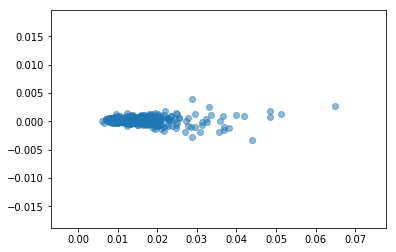

In [10]:
plt.scatter(std_l,rend_l, alpha=0.5)

Lors du classement on va favoriser les rendements a la volatilité

In [33]:
sort_rend = np.argsort(rend_l)
sort_std = np.argsort(std_l)

#classement
classement = np.zeros_like(sort_rend)
for i in range(len(sort_rend)):
    classement[sort_rend[i]] += i*30
    classement[sort_std[len(sort_rend)-1-i]] += i

## 3) Methode Naive (n=2)

Notre premiere approche est une methode dit "Brute force".  
En effet, nous allons essayer toute les possibilités, pour a la fin recupérer celle avec
la volatilité la plus faible.

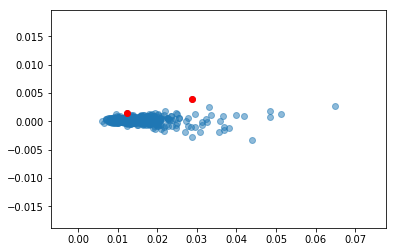

In [34]:
# on récupere les Deux meilleur
res = np.argsort(classement)[-2:]

plt.scatter(std_l,rend_l, alpha=0.5)
plt.scatter(std_l[res],rend_l[res], c="red")

rend: 0.0014043950869870798 & volatilité: 0.013455713793638755 -> poid: [0.32323232 0.67676768]


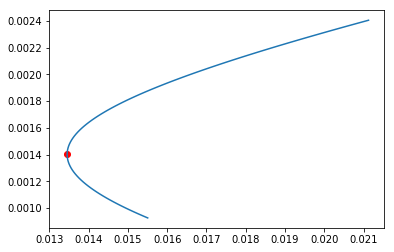

In [35]:
#On créé une matrice avec les rendements de chaque actif en column
mat_return = np.array(l_return.values[res])
mat_return = np.nan_to_num(mat_return)

#On va faire une list de tout les w possible
w = np.linspace(0, 1, num=100)
W = np.array([w, 1-w]).T

variance, std, rend = sharpe(W, mat_return)

#On récupere le minimum de volatilité
minimum = np.argmin(std)
print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {W[minimum]}")

plt.plot(std,rend)
plt.scatter(std[minimum], rend[minimum], c="red")

## Methode Naive à 3 actifs (n=3) 

[293 299 199]


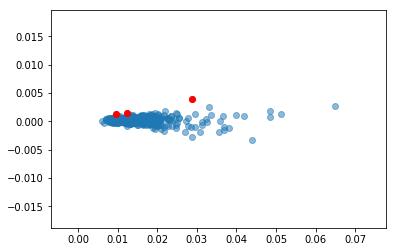

In [36]:
import itertools

w = np.linspace(0, 1, num=100)

n_w = np.array(list(itertools.permutations(w, 3)))

n_w = n_w[np.sum(n_w,axis=1) == 1]

res = np.argsort(classement)[-3:]
print(res)

plt.scatter(std_l,rend_l, alpha=0.5)
plt.scatter(std_l[res],rend_l[res], c="red")

In [37]:
mat_return = np.array(l_return.values[res])
mat_return = np.nan_to_num(mat_return)

variance, std, rend = sharpe(n_w, mat_return)

rend: -0.00023817324628645873 & volatilité: 0.009888739496865608 -> poid: [0.52525253 0.12121212 0.35353535]


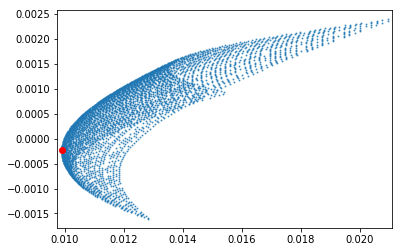

In [38]:
minimum = np.argmin(std)

print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {n_w[minimum]}")

plt.margins(x=0, y=-0.01)
plt.scatter(std,rend,s=1, alpha=0.7)
plt.scatter(std[minimum], rend[minimum], c="red")

# Optimization (minimal var) [avec Resolution analytique]

In [39]:
res = np.argsort(classement)[-2:]
mat_return = np.array(l_return.values[res])


> https://www.ephiquant.com/optimisation-de-portefeuille-modele-mean-variance-de-markowitz/

on cherche a optimiser le programme quadratique suivant

$$ 
 \left\{
    \begin{array}{ll}
       Min \ \sigma^2_p(w) = w^T\sigma w \\
       w^Tu = 1
    \end{array}
\right.$$

on va utiliser la méthode du multiplicateur de Lagrange:

$$
\mathcal{L}(\omega,\lambda) = \omega^\top \sigma \omega - \lambda(\omega^\top u-1)
$$

> où $\lambda$ est le multiplicateur de Lagrange

Nous allons ensuite calculer les dérivées partielles que nous allons spécifier égales à 0 : 

$$
\begin{cases} \frac{\partial\mathcal{L}}{\omega}= 2\sigma\omega-\lambda u=0 \quad \text{(a)}\\  \frac{\partial\mathcal{L}}{\partial\lambda}=\omega^\top u-1=0 \quad\quad\text{(b)}\end{cases}
$$

Nous allons d’abord tirer $\omega$ dans l’équation (a), après quoi nous allons le remplacer dans l’équation (b) par son expression: 

$$
\begin{split} \text{(a)} \quad 2\sigma\omega-\lambda u=0\quad  \implies \omega &= \frac{1}{2}\lambda\sigma^{-1}u \\ \text{(b)} \quad \omega^\top u-1=0 \implies \omega^\top u &= 1 \\ \frac{1}{2}\lambda u^\top\sigma^{-1}u &=1 \\  \lambda &= \frac{2}{u^\top\sigma^{-1}u} \end{split}
$$

Nous allons mettre cette dernière expression de $\lambda$ dans l’expression de $\omega$. Cela donnera ceci : 

$$
\begin{equation*}\omega=\frac{1}{2} \bigg(\frac{2}{u^{\top}\sigma^{-1}u} \bigg) \sigma^{-1}u \implies \omega=\frac{\sigma^{-1}u}{u^\top\sigma^{-1}u} \end{equation*}
$$

In [108]:
# u = [1, ..., 1]

In [40]:
r = rend_l[res]
u = np.ones(r.shape[0])

sigma = np.cov(mat_return)
sigma_inv = np.linalg.inv(sigma) 

w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)
w

array([0.32117265, 0.67882735])

rend: 0.0014043950869870798 & volatilité: 0.013455713793638755 -> poid: [0.32323232 0.67676768]
rend: 0.0014013527764560074 & volatilité: 0.013455623072398042 -> poid: [0.32117265 0.67882735]


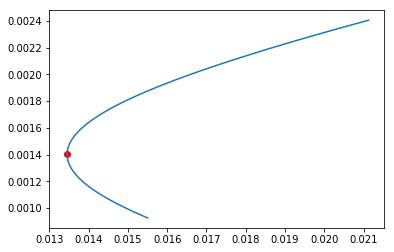

In [41]:
w_ = np.linspace(0, 1, num=100)
W = np.array([w_, 1-w_]).T

variance, std, rend = sharpe(W, mat_return)
minimum = np.argmin(std)
print(f"rend: {rend[minimum]} & volatilité: {std[minimum]} -> poid: {W[minimum]}")

plt.plot(std,rend)

variance, std, rend = sharpe(w, mat_return)
plt.scatter(std, rend, c="red")
print(f"rend: {rend} & volatilité: {std} -> poid: {w}")

## resolution analytique avec les 15 meilleurs actifs

In [43]:
res = np.argsort(classement)[-15:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)

sigma_inv = np.linalg.inv(sigma) 

w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)

w

array([0.06213325, 0.08559392, 0.06587923, 0.02094879, 0.13124295,
       0.09678613, 0.04536587, 0.00242421, 0.10328725, 0.0513458 ,
       0.08184854, 0.04572055, 0.0931008 , 0.03603642, 0.0782863 ])

In [44]:
variance, std, rend = sharpe(w, mat_return)
print(f"rend: {rend} & volatilité: {std} \n -> poid: {w}")

rend: 0.0016960728855557159 & volatilité: 0.003660608582344337 
 -> poid: [0.06213325 0.08559392 0.06587923 0.02094879 0.13124295 0.09678613
 0.04536587 0.00242421 0.10328725 0.0513458  0.08184854 0.04572055
 0.0931008  0.03603642 0.0782863 ]


## Benchmark

Regardons l'influence du nombre d'actif sur le rendement et la volatilité.

[2] rend: 0.0014013527764560074 & volatilité: 0.013455623072398042
[3] rend: -0.00024890848916578687 & volatilité: 0.009888508894080866
[4] rend: 0.0026531942068024916 & volatilité: 0.008428902503006498
[5] rend: 0.0030497959341531647 & volatilité: 0.007437229211439902
[6] rend: 0.0027629581039221793 & volatilité: 0.006466471656209896
[7] rend: 0.001971272718149064 & volatilité: 0.005277813412334054
[8] rend: 0.0020820894276347103 & volatilité: 0.005126140432448945
[9] rend: 0.0022036539242417815 & volatilité: 0.0050001301042632024
[10] rend: 0.0019486837189364398 & volatilité: 0.0046022513175907435
[11] rend: 0.001573851574937867 & volatilité: 0.004195744966396439
[12] rend: 0.0017593297959900475 & volatilité: 0.004150406518872483
[13] rend: 0.0019537680671588347 & volatilité: 0.0040097426143941555
[14] rend: 0.0016844105867934683 & volatilité: 0.003781788665742253
[15] rend: 0.0016960728855557159 & volatilité: 0.003660608582344337
[16] rend: 0.0016015738663242875 & volatilité: 0.0036

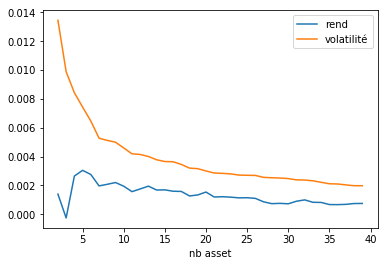

In [45]:
hist = []
for i in range(2,40,1):
    res = np.argsort(classement)[-i:]
    r = rend_l[res]
    u = np.ones(r.shape[0])
    mat_return = np.array(l_return.values[res])

    sigma = np.cov(mat_return)
    sigma_inv = np.linalg.inv(sigma) 

    w = (sigma_inv @ u) / (u.T @ sigma_inv @ u)
    variance, std, rend = sharpe(w, mat_return)
    print(f"[{i}] rend: {rend} & volatilité: {std}")
    hist.append([rend, std])

hist = np.array(hist)

plt.plot(range(2,40,1),hist[:,0], label="rend")
plt.plot(range(2,40,1),hist[:,1], label="volatilité")
plt.xlabel("nb asset")
plt.legend()

## Optimisation avec rendement fixé

In [46]:
res = np.argsort(classement)[-2:]
r = rend_l[res]
u = np.ones(r.shape[0])
mat_return = np.array(l_return.values[res])

sigma = np.cov(mat_return)
sigma_inv = np.linalg.inv(sigma) 

$$
\begin{equation*}\omega=E\mu_0+F\end{equation*}
$$

avec:

$$
E=\frac{1}{D}\sigma^{-1}(C\mu-Au)\quad \text{et} \quad F=\frac{1}{D}\sigma^{-1}(-A\mu+Bu)
$$


Nous allons définir 
- $A=u^\top\sigma^{-1}\mu=\mu^\top\sigma^{-1}u$ 
- $B=\mu^\top\sigma^{-1}\mu$ 
- $C=u^\top\sigma^{-1}u$
- $D=BC-A^2$

In [47]:
A = u.T @ sigma_inv @ r 
B = r.T @ sigma_inv @ r
C = u.T @ sigma_inv @ u
D = B*C - (A**2)

In [57]:
E = (1/D) * sigma_inv @ (C*r - A*u)
F = (1/D) * sigma_inv @ (-A*r + B*u)

w = E* 0.004 + F
w

array([0.99733108, 0.00266892])

In [52]:
variance, std, rend = sharpe(w, mat_return)
print(f"[{i}] rend: {rend} & volatilité: {std}")

[0.005] rend: 0.0012433380051725255 & volatilité: 0.01369817346744612


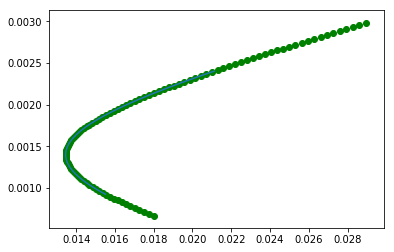

In [53]:
w_ = np.linspace(0, 1, num=100)
W = np.array([w_, 1-w_]).T


variance, std, rend = sharpe(W, mat_return)

minimum = np.argmin(std)
plt.plot(std,rend)

target_ = np.linspace(0.001, 0.005, num=100)
best = ""

for i in target_:
    w = E* i + F
    variance, std, rend = sharpe(w, mat_return)
    if std < rend:
        best = f"rend: {rend} & volatilité: {std}"
        plt.scatter(std, rend, c="red")
    else:
        plt.scatter(std, rend, c="green")
        
print(best)

En Rouge: rendement > risque  
En Vert : rendement < risque

## N=15

In [54]:
res = np.argsort(classement)[-15:]
mat_return = np.array(l_return.values[res])

In [61]:
def get_w(mat_return, u_t= 0.0017):
    r = mat_return.mean(axis=1)
    u = np.ones(r.shape[0])
    
    sigma = np.cov(mat_return)
    sigma_inv = np.linalg.inv(sigma) 
    
    A = u.T @ sigma_inv @ r 
    B = r.T @ sigma_inv @ r
    C = u.T @ sigma_inv @ u
    D = B*C - (A**2)
    
    E = (1/D) * sigma_inv @ (C*r - A*u)
    F = (1/D) * sigma_inv @ (-A*r + B*u)

    w = E* u_t + F
    return w


w_20 = get_w(mat_return, 0.003)
print(w_20)
sharpe(w_20, mat_return)

[-0.01260665  0.0634049   0.05432803  0.09798857  0.05709856  0.09991218
  0.07397107  0.05866646  0.01965285  0.08989254  0.03790177  0.10220652
  0.075023    0.06065088  0.04557214  0.07633718]


(array(1.59728841e-05), 0.003996609073250698, 0.003)

In [112]:
def checking_w(w):
    if np.sum(w<0) == 0:
        if np.sum((w >= 0.01) & (w <= 0.1)) == w.shape[0]:
            return True
    return False

checking_w(np.array([0.2, 0.05]))

False

15 0
16 0
17 0
18 0
19 0
20 0
21 0
22 0
23 0
24 0
25 0
26 0
27 0
28 0
29 0
30 0
31 0
32 0
33 0
34 0
35 0
36 0
37 0
38 0
39 0
15 1
16 1
17 1
18 1
19 1
20 1
21 1
22 1
23 1
24 1
25 1
26 1
27 1
28 1
29 1
30 1
31 1
32 1
33 1
34 1
35 1
36 1
37 1
38 1
39 1
15 2
16 2
17 2
18 2
19 2
20 2
21 2
22 2
23 2
24 2
25 2
26 2
27 2
28 2
29 2
30 2
31 2
32 2
33 2
34 2
35 2
36 2
37 2
38 2
39 2
15 3
16 3
17 3
18 3
19 3
20 3
21 3
22 3
23 3
24 3
25 3
26 3
27 3
28 3
29 3
30 3
31 3
32 3
33 3
34 3
35 3
36 3
37 3
38 3
39 3
15 4
16 4
17 4
18 4
19 4
20 4
21 4
22 4
23 4
24 4
25 4
26 4
27 4
28 4
29 4
30 4
31 4
32 4
33 4
34 4
35 4
36 4
37 4
38 4
39 4
15 5
16 5
17 5
18 5
19 5
20 5
21 5
22 5
23 5
24 5
25 5
26 5
27 5
28 5
29 5
30 5
31 5
32 5
33 5
34 5
35 5
36 5
37 5
38 5
39 5
15 6
16 6
17 6
18 6
19 6
20 6
21 6
22 6
23 6
24 6
25 6
26 6
27 6
28 6
29 6
30 6
31 6
32 6
33 6
34 6
35 6
36 6
37 6
38 6
39 6
15 7
16 7
17 7
18 7
19 7
20 7
21 7
22 7
23 7
24 7
25 7
26 7
27 7
28 7
29 7
30 7
31 7
32 7
33 7
34 7
35 7
36 7
37 7
38 7
39 7


17 8
0.00192, 0.0019219219219219223 , [0.05640281 0.04572063 0.03970854 0.0592507  0.04314337 0.04558461
 0.07232728 0.08831138 0.07081786 0.04731459 0.06528114 0.06916755
 0.07242181 0.05363055 0.09540629 0.06550863 0.01000225]
0.00195, 0.0019519519519519525 , [0.0568216  0.04543527 0.03949879 0.05980655 0.04219033 0.04607709
 0.07304875 0.08768894 0.0707515  0.04677454 0.06489087 0.06870123
 0.07319393 0.05466166 0.09488248 0.06501462 0.01056184]
0.00198, 0.0019819819819819826 , [0.05724039 0.04514991 0.03928905 0.06036239 0.04123729 0.04656958
 0.07377021 0.0870665  0.07068514 0.0462345  0.06450059 0.06823491
 0.07396605 0.05569277 0.09435867 0.06452061 0.01112143]
0.00201, 0.0020120120120120126 , [0.05765917 0.04486455 0.03907931 0.06091823 0.04028425 0.04706207
 0.07449168 0.08644407 0.07061878 0.04569446 0.06411031 0.06776859
 0.07473818 0.05672388 0.09383486 0.0640266  0.01168102]
0.00204, 0.0020420420420420426 , [0.05807796 0.04457919 0.03886956 0.06147407 0.03933121 0.04755456

19 8
0.00159, 0.0015915915915915915 , [0.06089762 0.02206539 0.06110468 0.04194543 0.02620182 0.06809553
 0.03811009 0.03282538 0.06837274 0.07009101 0.06818416 0.03902266
 0.06117201 0.05875894 0.08224719 0.04755846 0.08225444 0.06068251
 0.01040996]
0.00162, 0.0016216216216216218 , [0.06018372 0.02171291 0.06141164 0.04173991 0.02619416 0.06846472
 0.03736692 0.03341324 0.06903606 0.06980529 0.06816428 0.03866794
 0.06088661 0.05848116 0.08278626 0.04851988 0.08196033 0.06032624
 0.01087874]
0.00165, 0.0016516516516516518 , [0.05946982 0.02136044 0.0617186  0.04153439 0.0261865  0.06883391
 0.03662374 0.0340011  0.06969939 0.06951957 0.0681444  0.03831322
 0.0606012  0.05820338 0.08332534 0.0494813  0.08166622 0.05996998
 0.01134751]
0.00168, 0.0016816816816816811 , [0.05875592 0.02100796 0.06202556 0.04132887 0.02617884 0.0692031
 0.03588057 0.03458895 0.07036271 0.06923385 0.06812452 0.0379585
 0.0603158  0.05792561 0.08386441 0.05044272 0.08137211 0.05961371
 0.01181629]
0.00171, 

21 8
22 8
23 8
24 8
25 8
26 8
27 8
28 8
29 8
30 8
31 8
32 8
33 8
34 8
35 8
36 8
37 8
38 8
39 8
rend: 0.0029429429429429434 & volatilité: 0.0038411908881107286


array([0.07064159, 0.03601835, 0.03257726, 0.07814935, 0.01074003,
       0.06232918, 0.09685708, 0.06714849, 0.06856164, 0.02895313,
       0.05201171, 0.05331265, 0.09867398, 0.08868822, 0.0775968 ,
       0.0487122 , 0.02902832])

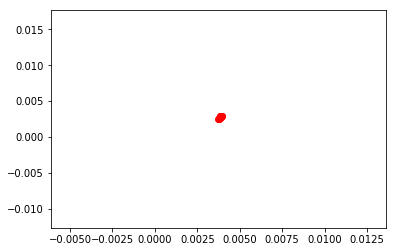

In [160]:
res = np.argsort(classement)[-15:]
mat_return = np.array(l_return.values[res])
target_ = np.linspace(0.000, 0.03, num=1000)
best = ""
W=np.array([])
actual_rend = -10
decal = 0
Res=[]

while len(W) == 0 and decal < 20:
    for j in range(15,40):
        print(j, decal)
        if decal > 0:
            res = np.argsort(classement)[-j-decal:-decal]
        else:
            res = np.argsort(classement)[-j:]
        mat_return = np.array(l_return.values[res])
        for i in target_:
            w = get_w(mat_return, i)
            if checking_w(w):
                variance, std, rend = sharpe(w, mat_return)
                print(f"{i:0.3}, {rend} , {w}")
                if actual_rend < rend:
                    Res=res
                    W=w
                    actual_rend= rend
                    best = f"rend: {rend} & volatilité: {std}"
                    plt.scatter(std, rend, c="red")
    decal+=1
        
print(best)
W

## Verification

Notre porte-feuille doit respecter plusieurs criteres:

- 50% stock en prix
- check la currency
- check les lots
- 1% a 10% par actif


In [161]:
def check_type(list_id):
    #df_asset = req.get_asset()[["ASSET_DATABASE_ID", "TYPE"]]
    mask = df_asset['ASSET_DATABASE_ID'].isin(list_id)
    pf_type = df_asset.loc[mask]["TYPE"].values
    #print(np.unique(pf_type, return_counts=True))
    return pf_type
    
    
check_type(l_id[Res])

array(['STOCK', 'STOCK', 'STOCK', 'STOCK', 'STOCK', 'STOCK', 'STOCK',
       'STOCK', 'STOCK', 'STOCK', 'STOCK', 'FUND', 'STOCK', 'STOCK',
       'STOCK', 'STOCK', 'STOCK'], dtype=object)

In [162]:
def check_currency(list_id):
    mask = df_asset['ASSET_DATABASE_ID'].isin(list_id)
    pf_type = df_asset.loc[mask]["CURRENCY"].values
    return pf_type
    
    
check_currency(l_id[Res])

array(['EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR',
       'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'EUR', 'USD', 'JPY'],
      dtype=object)

In [163]:
req.change_currency("EUR","USD")

1.1174

In [188]:
def get_amout(w, list_id, list_nav, solde= 100000000):
    
    stock_price = 0
    global_price = 0
    actif_price = []
    
    #On recupere la list de type d'actif et leur currency
    l_currency = check_currency(list_id)
    l_type = check_type(list_id)
    
    #On prend les prix de l'actif a la date
    start = dt.datetime.strptime('2016-06-01', '%Y-%m-%d')
    price = list_nav.loc[list_nav.index == start]
    
    #Pour chaque actif on recupere le nombre que l'on peut en acheter
    # nombre = (solde*poid) / prix d'une action
    nb_actif= []
    for i in range(len(list_id)):
        unit_price = price[list_id[i]].values[0]
        if l_currency[i] != "EUR":
            r = req.change_currency(l_currency[i],"EUR")
            unit_price = r * unit_price
            
        nb = int((solde*w[i])//unit_price)
        
        if l_type[i] == "STOCK":
            stock_price+= nb*unit_price
        global_price += nb*unit_price
        
        nb_actif.append(nb)
        actif_price.append(nb*unit_price)
        
    actif_price = np.array(actif_price)
    print("% de chaque actif :",actif_price/global_price)
    print(f"Stock % :{(stock_price/global_price):0.2}")
    return np.array(nb_actif)
    
    
get_amout(W, l_id[Res], list_nav)

% de chaque actif : [0.07064214 0.03601813 0.03257753 0.07814997 0.01074004 0.06232311
 0.09685786 0.06714883 0.06856191 0.02895337 0.05201201 0.05331307
 0.09867479 0.0886889  0.07759727 0.04871251 0.02902856]
Stock % :0.95


array([   113938,     24636,  23269473,    678969,     34645,      2155,
          353622,    114803,    159445,   3308929,    264690,   1241272,
       109637761,   1009541,    358414,    557123,   7598462])

Nous verrifions si le montant de stock est bien superieur a 50%

In [181]:
def get_asset_pf(W, list_id, list_nav):
    nb = get_amout(W,list_id,list_nav)
    nb = np.nan_to_num(nb)
    ret = []
    for i in range(len(list_id)):
        js = {}
        js["asset"] = int(list_id[i])
        js["quantity"] = int(nb[i])
        ret.append({"asset": js})
    return ret

new_pt = get_asset_pf(W, l_id[Res], list_nav)
new_pt

Stock % :0.95


[{'asset': {'asset': 1910, 'quantity': 113938}},
 {'asset': {'asset': 1591, 'quantity': 24636}},
 {'asset': {'asset': 2043, 'quantity': 23269473}},
 {'asset': {'asset': 1882, 'quantity': 678969}},
 {'asset': {'asset': 1862, 'quantity': 34645}},
 {'asset': {'asset': 2120, 'quantity': 2155}},
 {'asset': {'asset': 1538, 'quantity': 353622}},
 {'asset': {'asset': 1872, 'quantity': 114803}},
 {'asset': {'asset': 1990, 'quantity': 159445}},
 {'asset': {'asset': 2035, 'quantity': 3308929}},
 {'asset': {'asset': 1912, 'quantity': 264690}},
 {'asset': {'asset': 1884, 'quantity': 1241272}},
 {'asset': {'asset': 1959, 'quantity': 109637761}},
 {'asset': {'asset': 1877, 'quantity': 1009541}},
 {'asset': {'asset': 2058, 'quantity': 358414}},
 {'asset': {'asset': 1956, 'quantity': 557123}},
 {'asset': {'asset': 2112, 'quantity': 7598462}}]

## Porte-Feuille

In [182]:
new_portfolio = {
    "label":"EPITA_PTF_8",
    "currency": {
        "code":"EUR"
    },
    "type":"front",
    "values": {
        "2016-06-01": new_pt
    }
}
pp = json.dumps(new_portfolio)

In [183]:
req.push(pp).text

''

In [184]:
portfolio = req.get_portfolio()
portfolio

'{"label":"EPITA_PTF_8","currency":{"code":"EUR"},"type":"front","values":{"2016-06-01":[{"asset":{"asset":2112,"quantity":7598462.0}},{"asset":{"asset":1538,"quantity":353622.0}},{"asset":{"asset":1956,"quantity":557123.0}},{"asset":{"asset":1862,"quantity":34645.0}},{"asset":{"asset":1990,"quantity":159445.0}},{"asset":{"asset":1959,"quantity":1.09637761E8}},{"asset":{"asset":2120,"quantity":2155.0}},{"asset":{"asset":2058,"quantity":358414.0}},{"asset":{"asset":1872,"quantity":114803.0}},{"asset":{"asset":2035,"quantity":3308929.0}},{"asset":{"asset":1877,"quantity":1009541.0}},{"asset":{"asset":1910,"quantity":113938.0}},{"asset":{"asset":1591,"quantity":24636.0}},{"asset":{"asset":1912,"quantity":264690.0}},{"asset":{"asset":1882,"quantity":678969.0}},{"asset":{"asset":2043,"quantity":2.3269473E7}},{"asset":{"asset":1884,"quantity":1241272.0}}]}}'